In [13]:
import pandas as pd

# Load the dataset
df = pd.read_csv('diabetes.csv')

# Display the first few rows of the dataframe
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
# Check for missing values
print(df.isnull().sum())

# Replace zeros with NaN in columns where zero is not possible (e.g., Glucose, BloodPressure, SkinThickness, Insulin, BMI)
import numpy as np
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[columns] = df[columns].replace(0, np.nan)

# Fill missing values with the mean of each column
df.fillna(df.mean(), inplace=True)

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Scale the features
df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('Outcome', axis=1)), columns=df.columns[:-1])
df_scaled['Outcome'] = df['Outcome']

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Scale the features to a non-negative range
df_scaled_non_negative = pd.DataFrame(scaler.fit_transform(df_scaled.drop('Outcome', axis=1)), columns=df_scaled.columns[:-1])
df_scaled_non_negative['Outcome'] = df_scaled['Outcome']

# Select top k features
selector = SelectKBest(score_func=chi2, k=4)
X_new = selector.fit_transform(df_scaled_non_negative.drop('Outcome', axis=1), df_scaled_non_negative['Outcome'])

# Get selected feature names
features = df_scaled_non_negative.drop('Outcome', axis=1).columns[selector.get_support(indices=True)]
print("Selected features:", features)

Selected features: Index(['Pregnancies', 'Glucose', 'BMI', 'Age'], dtype='object')


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_new, df_scaled['Outcome'], test_size=0.3, random_state=42)

# Initialize and train the classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
# Create a dictionary with the metrics
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"],
    "Score": [
        f"{accuracy_score(y_test, y_pred):.4f}",
        f"{precision_score(y_test, y_pred):.4f}",
        f"{recall_score(y_test, y_pred):.4f}",
        f"{f1_score(y_test, y_pred):.4f}",
        f"{roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}"
    ]
}

# Print the metrics in a tabular format
print("{:<10} {:<10}".format('Metric', 'Score'))
print("-" * 21)
for metric, score in zip(metrics["Metric"], metrics["Score"]):
    print("{:<10} {:<10}".format(metric, score))


Metric     Score     
---------------------
Accuracy   0.7403    
Precision  0.6515    
Recall     0.5375    
F1 Score   0.5890    
ROC-AUC    0.7903    


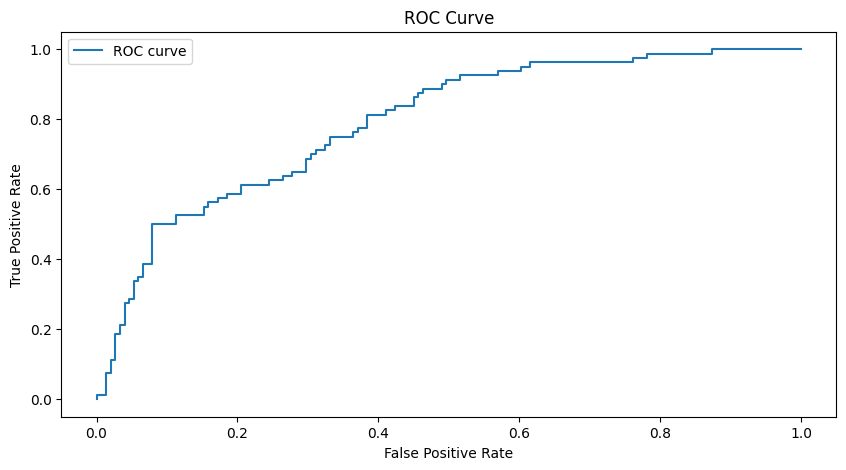

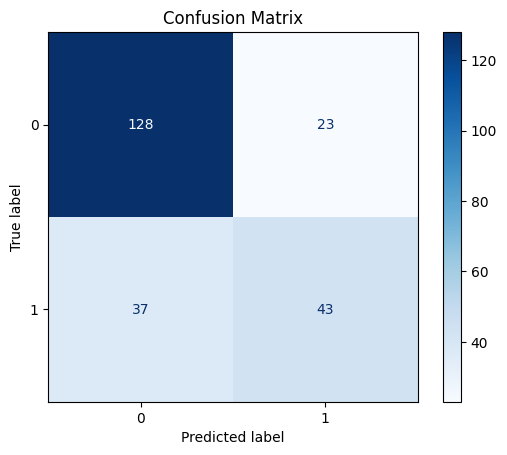

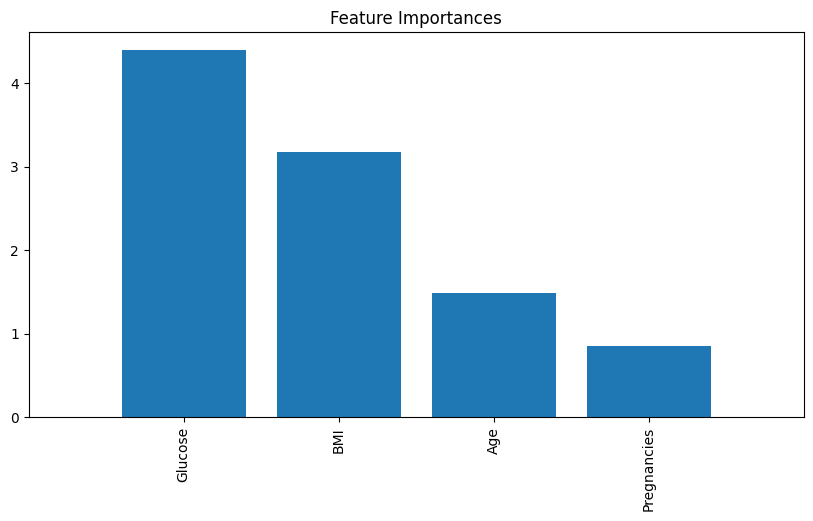

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = model.coef_[0]
indices = np.argsort(importances)[::-1]
feature_names = features

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()